In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

import matplotlib.patches as patches

In [2]:
H = 40
W = 40
h = H-1
w = W-1

n_min = 2
n_max = 5

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.72576162 0.875      0.115      0.115     ]
 [0.54302035 0.625      0.16452029 0.16452029]
 [0.32199579 0.375      0.13649981 0.13649981]
 [0.63842973 0.125      0.15351054 0.1551069 ]]
[1. 1. 1. 0.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = j/(W-1)
        anchors[i,j,:,1] = i/(H-1)
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

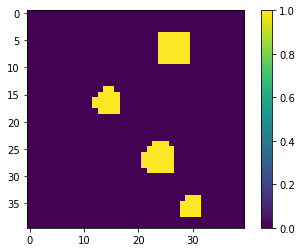

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.0001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=20, hidden_size=256)

rcnn     = net.RCNN(backbone, rpn, anchors, backbone_channels=1, 
                   window_size=10, hidden_size=256, num_classes=3, obj_threshold=0.8, scope='rcnn')


crop_conv = rcnn(x_tf)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_sum(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = 10*tf.reduce_sum(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

lab_sum = tf.reduce_sum(y_label_tf)

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0828 09:09:44.358222 140221268633344 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0828 09:09:44.360302 140221268633344 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:14: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0828 09:09:44.361376 140221268633344 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0828 09:09:44.488350 140221268633344 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Sum_1:0", shape=(), dtype=float32) Tensor("mul_7:0", shape=(), dtype=float32) Tensor("add_2:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l,lc,lb,ls = sess.run([loss, loss_class, loss_box, lab_sum], {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.3f} loss_class={:.3f} loss_box={:.3f}, lab_sum={:.1f}".format(i,l, lc, lb, ls))

iteration 0: loss=4345.227 loss_class=4342.032 loss_box=3.194, lab_sum=8.0


E0828 09:11:07.243666 140221268633344 ultratb.py:147] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-b88f0b3854ba>", line 11, in <module>
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 950, in run
    run_metadata_ptr)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1173, in _run
    feed_dict_tensor, options, run_metadata)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1350, in _do_run
    run_metadata)
  File "/home/marsdenlab/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1356, in _do_call
    return fn(*args)
  File "/home/marsdenlab/anaconda3/lib/pyt

KeyboardInterrupt: 

In [ ]:
x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)

gt_t, gt_matched, gt_labels, gt_weights =\
box.create_box_gt(anchors_1d, gt_box)

x = x.reshape((1,H,W,1))

out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

In [ ]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [ ]:
predicted_boxes, predicted_obj = sess.run([list_box, list_obj],{x_tf:x})

In [ ]:
anch_p = anchors.reshape((-1,4))[predicted_obj>0.9]
print(anch_p)

In [ ]:
bp = predicted_boxes[predicted_obj>0.9]
print(bp)

In [ ]:
gt_p = gt_t[predicted_obj>0.9]
print(gt_p)

In [ ]:
bp_n = box.inv_bbox_transform(anch_p, bp)
gt_n = box.inv_bbox_transform(anch_p, gt_p)
print(bp_n*H)
print(gt_n*H)
print(gt_box*H)

In [ ]:
# Create figure and axes
fig,ax = plt.subplots(1, figsize=(8,8))

# Display the image
ax.imshow(x[0,:,:,0])

# Create a Rectangle patch
for b in bp_n:
    rect = patches.Rectangle((int(b[0]*w),int(b[1]*h)),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Create a Rectangle patch
for b in gt_box:
    rect = patches.Rectangle((int(b[0]*w)-0.5,int(b[1]*h)-0.5),int(b[2]*H),int(b[3]*H),linewidth=1,
                             edgecolor='g',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [ ]:
cropped = sess.run(crop_conv,{x_tf:x})

In [ ]:
print(cropped.shape)

In [ ]:
for n in range(cropped.shape[0]):
    plt.figure()
    plt.imshow(cropped[n,:,:,0])
    plt.show()